In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import wcs, coordinates, table
from astropy import units as u
from astropy.io import fits

from ekfplot import plot as ek
from ekfplot import colors as ec
from agrias import photometry, utils
from carpenter import emission, conventions, pixels

In [3]:
catalog = pd.read_parquet('../../carpenter/data/MDR1_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')
catalog = catalog.set_index('objectId_Merian')
catalog.index = [ f'M{sidx}' for sidx in catalog.index ]

In [ ]:
av, u_av = emission.estimate_av(catalog,)
catalog['AV'] = av
catalog['u_AV'] = u_av

emission_corrections = emission.compute_emissioncorrections(catalog, logmstar_key='logmass_gaap1p0')

In [6]:
ancline_correction, ge_correction, extinction_correction, catalog_apercorr = emission_corrections

n708_fluxes, n708_luminosities, n708_eqws, n708_fcont = photometry.mbestimate_halpha(
    catalog[utils.photcols['N708']].values,
    catalog[utils.photcols['g']].values,
    catalog[utils.photcols['r']].values,
    catalog[utils.photcols['i']].values,
    catalog[utils.photcols['z']].values,
    np.full(len(catalog),0.08),
    catalog[utils.u_photcols['N708']].values,
    0.,
    0.,
    band='n708',
    apercorr=1.,
    ge_correction=ge_correction[:,2],
    ex_correction=extinction_correction[0,:,2],
    u_ex_correction = 0.*extinction_correction[1,:,2], # \\ we're actually going to do dust errors downstream
    ns_correction=ancline_correction[:],
    do_aperturecorrection=False,
    do_gecorrection=False,
    do_extinctioncorrection=False,
    do_linecorrection=True,
    specflux_unit=u.nJy,
    ctype='powerlaw',
    plawbands='riz',
) 

n540_fluxes, n540_luminosities, n540_eqws, n540_fcont = photometry.mbestimate_halpha(
    catalog[utils.photcols['N540']].values,
    catalog[utils.photcols['g']].values,
    catalog[utils.photcols['r']].values,
    catalog[utils.photcols['i']].values,
    catalog[utils.photcols['z']].values,
    np.full(len(catalog),0.08),
    catalog[utils.u_photcols['N540']].values,
    0.,
    0.,
    band='n540',
    apercorr=1.,
    ge_correction=ge_correction[:,2],
    ex_correction=extinction_correction[0,:,2],
    u_ex_correction = 0.*extinction_correction[1,:,2], # \\ we're actually going to do dust errors downstream
    ns_correction=ancline_correction[:],
    do_aperturecorrection=False,
    do_gecorrection=False,
    do_extinctioncorrection=False,
    do_linecorrection=True,
    specflux_unit=u.nJy,
    ctype='linear',
    plawbands='gr',
) 

/home/kadofong/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))


In [9]:
from ekfphys import calibrations

catalog['haew'] = n708_eqws[0].value
catalog['oiiiew'] = np.where(catalog['logmass']<9.6, n540_eqws[0].value, np.nan)
catalog['rmag'] = -2.5*np.log10(catalog['r_cModelFlux_Merian']*1e-9/3631.)
catalog['F_Ha_obs'] = n708_fluxes[0].value * catalog_apercorr
catalog['L_Ha'] = ( n708_luminosities[0].value * extinction_correction[0,:,2] * ge_correction[:,2] * catalog_apercorr )
catalog['L_OIII'] = n540_luminosities[0].value * extinction_correction[0,:,3] * ge_correction[:,3] * catalog_apercorr
catalog['n540_apercorr'] = catalog['N540_cModelFlux_Merian']/catalog['N540_gaap1p0Flux_Merian']
catalog['i_apercorr'] = catalog['i_cModelFlux_Merian']/catalog['i_gaap1p0Flux_aperCorr_Merian']
catalog['lineratio'] = catalog.loc[:, 'L_OIII']/catalog.loc[:, 'L_Ha']
catalog['pz'] = catalog['pz1']+catalog['pz2']+catalog['pz3']+catalog['pz4']

is_mcmass = (catalog['logmass']>7.75)&(catalog['logmass']<9.4)&(catalog['i_apercorr']<4.)&(catalog['n540_apercorr']<4.)
is_emitter = (catalog['haew']>5.)&(catalog['oiiiew']>5.)
in_band = (catalog['z_spec']>0.05)&(catalog['z_spec']<0.11)
zphot_select = catalog['pz']>0.26
is_good = is_mcmass & zphot_select

z = 0.08
alpha = -0.13*z + 0.8
sfr0 = 1.24*z - 1.47
sigma = 0.22*z + 0.38
is_starburst = catalog['L_Ha'] > calibrations.SFR2LHa(10.**(alpha * (catalog['logmass'] - 8.5) + sfr0 + 1.5*sigma))

has_zspec = np.isfinite(catalog['z_spec'])
in_band = (catalog['z_spec']>0.05)&(catalog['z_spec']<0.11)
#in_band[~has_zspec] = np.nan

oiii_excess = catalog.loc[is_good&is_starburst&in_band]
oiii_excess[['RA','DEC']].to_csv('../../pixel_excess/scripts/oiii_excess.txt', index=False, header=False, sep=' ')



/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, '${\\rm L}({\\rm H\\alpha})$ [$\\rm erg\\ s^{-1}$]')

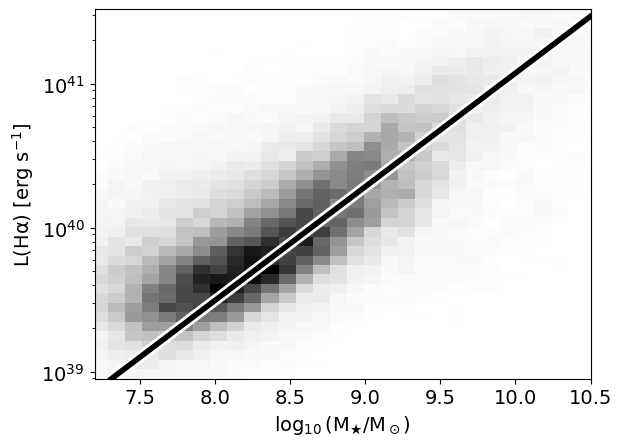

In [88]:
cx = catalog.query('pz>0.3')
ek.hist2d(
    cx['logmass'],
    cx['L_Ha'],
    bins=40,
    yscale='log'
)
lm = np.linspace(7., 10.5,30)
ek.outlined_plot(
    lm,
    calibrations.SFR2LHa(10.**(alpha * (lm - 8.5) + sfr0))
)
plt.yscale('log')
plt.xlim(7.2, 10.5)
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.common_labels['halum'])

In [77]:
from astropy import cosmology
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [79]:
10.**(alpha * (8. - 8.5) + sfr0 + 1.5*sigma)

0.06773295140086069

In [78]:
calibrations.SFR2LHa(10.**(alpha * (8. - 8.5) + sfr0 + 1.5*sigma)) / (4.*np.pi*cosmo.luminosity_distance(0.08).to(u.cm)**2)

<Quantity 7.7997488e-16 1 / cm2>

/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<Axes: >,
 (array([  62.,  120.,  219.,  352.,  501.,  621.,  703.,  765.,  770.,
          824.,  896.,  985., 1171., 1140., 1062.,  917.,  630.,  423.,
          225.]),
  array([1.04510787e-17, 1.55938941e-17, 2.32674102e-17, 3.47169458e-17,
         5.18006222e-17, 7.72909137e-17, 1.15324587e-16, 1.72074046e-16,
         2.56749045e-16, 3.83091311e-16, 5.71604668e-16, 8.52882556e-16,
         1.27257298e-15, 1.89878662e-15, 2.83315038e-15, 4.22730022e-15,
         6.30748980e-15, 9.41130876e-15, 1.40424694e-14, 2.09525532e-14]),
  <BarContainer object of 19 artists>))

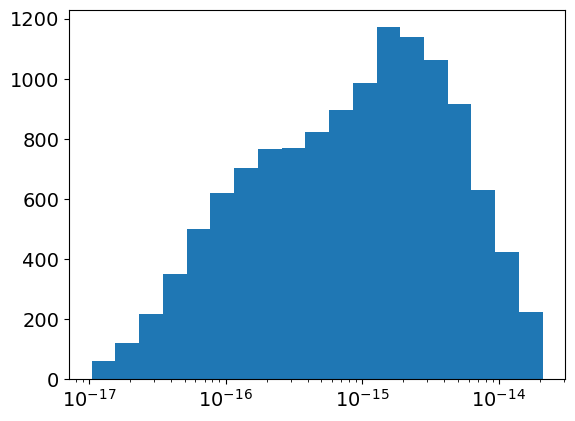

In [54]:
ek.hist(catalog.loc[has_zspec, 'F_Ha_obs'], bintype='log')

In [37]:
from ekfstats import sampling

In [72]:
catalog['pz'].min()

0.10000109654046599

In [57]:
dz =  abs(catalog['z500'] - catalog['z_spec'])/(1. + catalog['z_spec'])
catalog.loc[has_zspec&(dz>0.1), ['z500','z_spec','pz']]

,z500,z_spec,pz
M2950315152764853415,0.082984,0.923389,0.660647
M2950354735183450836,0.059649,2.732373,1.068329
M2950381123462527252,0.103599,1.861954,0.378380
M2950385521509038346,0.086332,0.644200,0.806566
M2950605423834569776,0.217903,0.042516,0.296162
...,...,...,...
M3670358929516304561,0.243021,0.072502,0.868040
M3670363327562804060,0.248361,0.068483,0.130035
M3670363327562805288,0.243057,0.067609,0.539578
M3670433696306962823,0.212286,0.099967,0.371834


(0.0, 0.12)

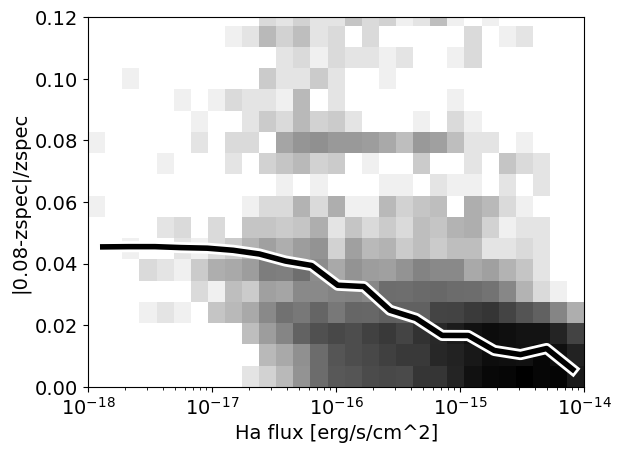

In [74]:
cx = catalog
_=ek.hist2d(
    cx['F_Ha_obs'],
    abs(0.08 - cx['z_spec'])/(1. + cx['z_spec']),
    bins=[np.logspace(-18,-14,30),np.linspace(0., 0.2, 30)],
    #yscale='log',
    xscale='log',
    zscale='log',
)
_=ek.running_quantile(
    cx['F_Ha_obs'],
    abs(0.08 - cx['z_spec'])/(1. + cx['z_spec']),
    bins=np.logspace(-18,-14,20),
    erronqt=False,
    show_std=False,
    std_format='fill_between',
    std_alpha=0.
)
plt.ylabel('|0.08-zspec|/zspec')
plt.xlabel('Ha flux [erg/s/cm^2]')
plt.xlim(1e-18,1e-14)
plt.ylim(0.,0.12)

In [10]:
row = catalog.loc['M3320023738581278548']
target = conventions.produce_merianobjectname(row.RA,row.DEC)
#target = 'J100041.30-000708.70'
# 'J100101.60+032717.50' -- super offset bright OIII emitter
targetid = conventions.merianobjectname_to_catalogname(target, catalog)
targetindex = np.where(np.in1d(catalog.index,targetid))[0][0]


In [12]:
bbmb = pixels.BBMBImage()
dirname = '../local_data/MDR1_mcmasses/'
for band in ['g','n540','r','n708','i','z',]:
    if band in ['n540','n708']:
        cutout = f'{dirname}/merian/{target}_{band.upper()}_merim.fits'
        psf = f'{dirname}/merian/{target}_{band.upper()}_merpsf.fits'
    else:
        cutout = f'{dirname}/hsc/{target}_HSC-{band}.fits'
        psf = f'{dirname}/hsc/{target}_HSC-{band}_psf.fits'
    
    bbmb.add_band(
        band,
        coordinates.SkyCoord(catalog.loc[targetid,'RA'],catalog.loc[targetid,'DEC'], unit='deg'),
        size=100,
        image=cutout,#['IMAGE'],
        var=cutout,#['VARIANCE'],
        psf=psf,#[0]
        image_ext=(1),
        var_ext=(3),
        psf_ext=0
    )

In [13]:
#fwhm_a, _ = bbmb.measure_psfsizes()
#mim, mpsf = bbmb.match_psfs ( np.argmax(fwhm_a), )

In [14]:
excess_bbmb = pixels.BBMBImage()
continuum_bbmb = pixels.BBMBImage()
fcs ={'n540':n540_fcont,'n708':n708_fcont}

for band in ['n540','n708']:
    fwhm_a, _ = bbmb.measure_psfsizes()
    mim, mpsf = bbmb.match_psfs ( refband=band, )    
    excess_bbmb.image[band], excess_bbmb.var[band]= bbmb.compute_mbexcess(
        band, 
        psf_matched=True,
        method='single',
        scaling_band='z',
        scaling_factor=fcs[band][targetindex].value/catalog.loc[targetid,utils.photcols['z']],
    )
    excess_bbmb.bands.append(band)
    

[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.
    Convolving matching kernel for g ...
         ... Done.
    Convolving matching kernel for r ...
         ... Done.
    Convolving matching kernel for n708 ...
         ... Done.
    Convolving matching kernel for i ...
         ... Done.
    Convolving matching kernel for z ...
         ... Done.
[SEDMap] Matching PSFs
    Copying to matched arrays ... 
        ... Done.
    Convolving matching kernel for g ...
         ... Done.
    Convolving matching kernel for n540 ...
         ... Done.
    Convolving matching kernel for r ...
         ... Done.
    Convolving matching kernel for i ...
         ... Done.
    Convolving matching kernel for z ...
         ... Done.


In [15]:
from ekfstats import sampling, fit
from astropy.visualization import make_lupton_rgb
from photutils.segmentation import detect_sources, deblend_sources, make_2dgaussian_kernel, SourceCatalog
from astropy.convolution import convolve

excess_bbmb.clean_nonexcess_sources ()

ancline_correction, ge_correction, extinction_correction, _ = emission_corrections

emission_bundle = {}
correction_indices = {'n540':3,'n708':2}
for band in ['n540','n708']:    
    # Segment image for source detection
    detimage = excess_bbmb.image[band] 
    segm = detect_sources(
        detimage, 
        threshold=5.*sampling.sigmaclipped_std(excess_bbmb.image[band], low=4., high=3.),
        npixels=5,
        connectivity=8
    )
    segm_deblend = deblend_sources(detimage, segm,
                           npixels=10, nlevels=32, contrast=0.001,
                           progress_bar=False)
    cat = SourceCatalog(detimage, segm_deblend)

    model_obj, model_pred = fit.fit_multi_moffat_2d(
        excess_bbmb.image[band],
        init_x_0=cat.xcentroid,
        init_y_0=cat.ycentroid,
        psf_fwhm=bbmb.fwhm_to_match
    )  

    #if len(emcat) == 0:
    #    print('No source detected in ' + band)
    #    emission_bundle[band] = (None,None,np.nan,np.nan)
    #    continue
    #ecatindex = emseg[emseg.shape[0]//2, emseg.shape[1]//2] - 1
    conversion = 10.**(-0.4*(27-31.4))
    #integrated_flux = emission.excess_to_lineflux(float(table.Table(emcat)[ecatindex]['flux'])*conversion*u.nJy, band=band)
    integrated_flux = emission.excess_to_lineflux(cat.kron_flux*conversion*u.nJy, band)
    integrated_flux_corrected = integrated_flux * extinction_correction[0][targetindex,correction_indices[band]]
    integrated_flux_corrected *= ge_correction[targetindex,correction_indices[band]]
    if band == 'n708':
        integrated_flux_corrected *= ancline_correction[targetindex]


    detimage = bbmb.image[band]
    segm = detect_sources(
            detimage, 
            threshold=5.*sampling.sigmaclipped_std(bbmb.image[band], low=4., high=3.),
            npixels=5,
            connectivity=8
        )
    total_segm_deblend = deblend_sources(detimage, segm,
                           npixels=10, nlevels=32, contrast=0.001,
                           progress_bar=False)
    total_cat = SourceCatalog(excess_bbmb.image[band], total_segm_deblend)
    catindex = total_segm_deblend.get_index(total_segm_deblend.data[detimage.shape[0]//2, detimage.shape[1]//2])
    
    total_flux = emission.excess_to_lineflux(total_cat.kron_flux[catindex]  * conversion *u.nJy, band)
    total_flux *= extinction_correction[0][targetindex,correction_indices[band]] * ge_correction[targetindex,correction_indices[band]]
    if band == 'n708':
        total_flux *= ancline_correction[targetindex]    

    emission_bundle[band] = (cat, segm_deblend, total_flux, integrated_flux_corrected, model_pred)

In [16]:
gamma = 1.3
alpha = 2.5
amplitude = 1.3
mmod = fit.Moffat2D(amplitude=amplitude, x_0=50, y_0=50, gamma=gamma, alpha=alpha)

from ekfstats import functions

y,x=np.mgrid[:100,:100]

print(mmod(x,y).sum())

4.651428792763208


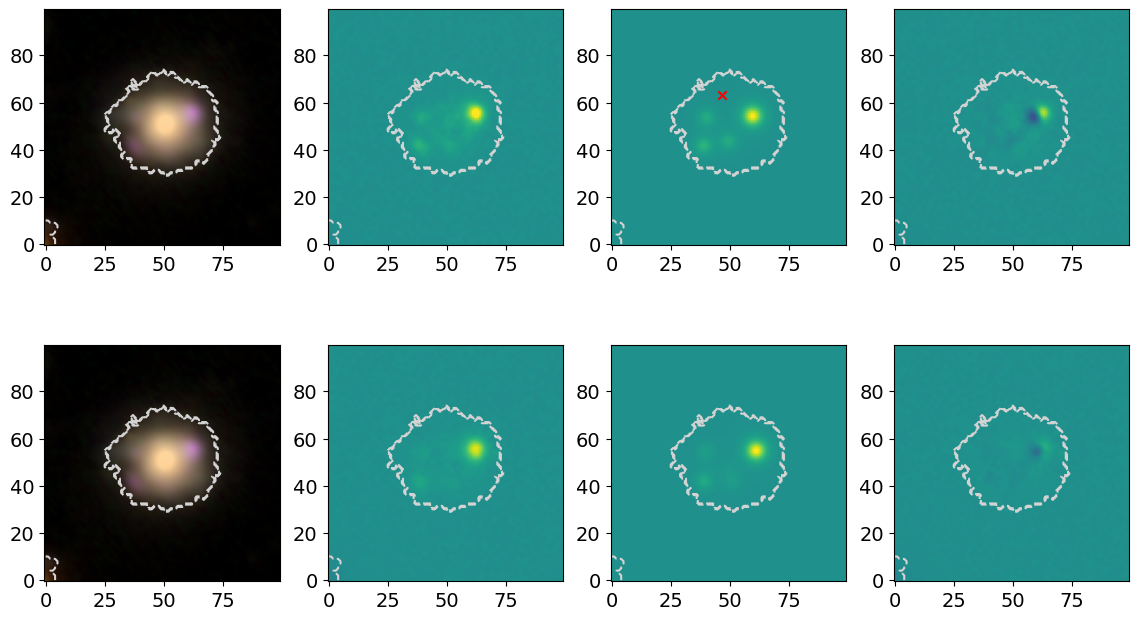

In [22]:
fig,axarr = plt.subplots(2,4, figsize=(14,8))

for adx,band in enumerate(['n708','n540']):
    ek.imshow( 
        make_lupton_rgb(
            bbmb.matched_image['i'],
            bbmb.matched_image['r'],
            bbmb.matched_image['g'],
            stretch=3.,
            Q=4),
        ax=axarr[adx,0]
    )
    for ax in axarr[adx]:
        ek.contour(
            segm,
            levels=[0,1],
            ax=ax,
            linestyles='--',
            colors='lightgrey'
        )
    
    model_pred = emission_bundle[band][-1]
    alpha = 1e-4
    lim = np.nanquantile(model_pred,1.-alpha)
    axarr[adx,1].imshow(excess_bbmb.image[band], vmin=-lim, vmax=lim, origin='lower')
    #plt.colorbar(im,ax=ax)
    axarr[adx,2].imshow(model_pred, vmin=-lim, vmax=lim, origin='lower')
    #plt.colorbar(im,ax=ax)
    axarr[adx,3].imshow(excess_bbmb.image[band] - model_pred, vmin=-lim, vmax=lim,origin='lower')
    #plt.colorbar(im,ax=ax)

axarr[0,2].scatter(46.616072,63.051358, color='r', marker='x')

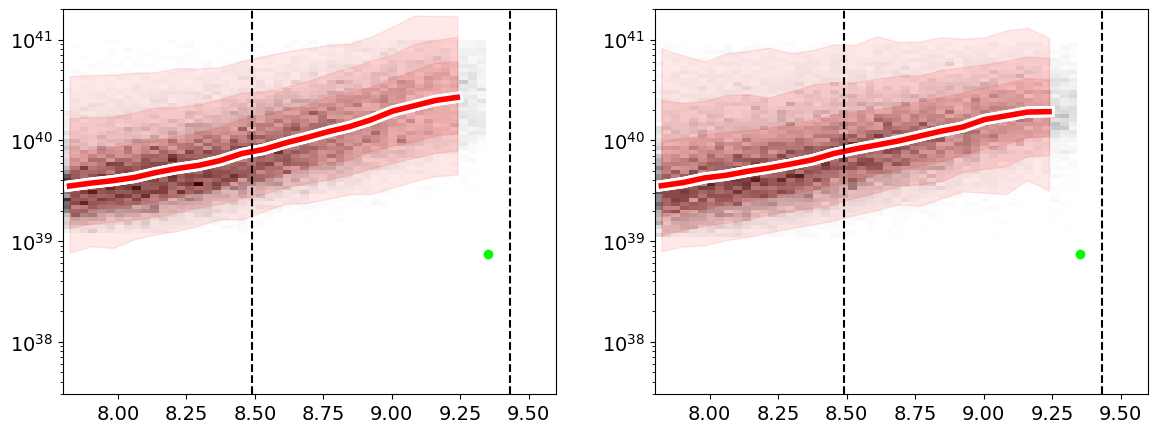

In [202]:
fig, axarr = plt.subplots(1,2,figsize=(14,5))
cosmo = emission.cosmo
for adx,key in enumerate(['L_Ha','L_OIII']):
    im,ax=ek.hist2d(
        catalog.loc[is_good&is_emitter, 'logmass'],
        catalog.loc[is_good&is_emitter, key],
        #np.log10(catalog['L_OIII']/catalog['L_Ha']).loc[is_good],
        yscale='log',
        bins=50,
        ax=axarr[adx],

        #cmap='coolwarm',
    )    
    for qt in [0.01,0.05,0.16]:
        _=ek.running_quantile(
            catalog.loc[is_good&is_emitter, 'logmass'],
            catalog.loc[is_good&is_emitter, key],
            bins=20,
            std_format='fill_between',
            color='r',    
            ax=axarr[adx],
            alpha=qt,
            std_alpha=0.09
        )
    
    


    region_flux = emission_bundle[band][3]
    region_lum = region_flux * 4.*np.pi*cosmo.luminosity_distance(0.08)**2
    region_lum = region_lum.to(u.erg/u.s)

    total_flux = emission_bundle[band][2]
    total_lum = (total_flux * 4.*np.pi*cosmo.luminosity_distance(0.08)**2).to(u.erg/u.s)
    axarr[adx].scatter(
        catalog.loc[targetid, 'logmass'],
        total_lum.value,
        zorder=3,
        color='lime'
    )
    axarr[adx].scatter(
        catalog.loc[targetid, 'logmass'],
        total_lum.value - max(region_lum).value,
        color='b'
    )

for ax in axarr:
    ax.axvline(np.log10(2.7)+9., color='k', ls='--') # LMC M*, van der Marel 2006
    ax.axvline(np.log10(3.1)+8., color='k', ls='--') # SMC M*, Besla + 2011
    ax.set_ylim(3e37,2e41)
    ax.set_xlim(7.8,9.6)
#plt.colorbar(im,ax=ax)

In [193]:
 catalog.loc[targetid, 'logmass'], total_lum

(9.176157677907046, <Quantity 1.87008878e+41 erg / s>)

In [194]:
region_lum

<Quantity [1.86759756e+41] erg / s>